In [8]:
from pathlib import Path
from collections import Counter
import re
from pypdf import PdfReader
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

pl_cfg = pl.Config()

# Adding Data to the Kaggle Dataset
### 1. Read in additional scripts from PDF (manually downloaded from Google searches)
### 2. Join to the Kaggle Internet Movie Script Dataset
### 3. Join the result to the Kaggle IMDB dataset containing the year and genre of each film
### 4. Clean and Save

The final dataset is 110 scripts with their year and genre from
- https://www.kaggle.com/datasets/prasad22/the-internet-movie-script-dataset
- Downloading PDFs from Google Searches
- https://www.kaggle.com/datasets/ashirwadsangwan/imdb-dataset?select=title.basics.tsv

In [9]:
# data I already have from the kaggle internet-movie-script dataset
df = pl.read_parquet("data/in/cleaned-kaggle-internet-movie-script.parquet")

### Load Data In

In [10]:
additional_script_pdfs = list(Path("data/in/").glob("*.pdf"))
print(len(additional_script_pdfs), " new scripts.\n")
print("\n".join([p.name for p in additional_script_pdfs]))

52  new scripts.

It's a Wonderful Life.pdf
Oppenheimer.pdf
All Quiet On The Western Front.pdf
Seven Samurai.pdf
Gladiator 2.pdf
The Northman.pdf
The-Batman.pdf
Wonka.pdf
Moana 2.pdf
The Silence of the Lambs.pdf
Twisters.pdf
12 Angry Men.pdf
The Shawshank Redemption.pdf
Avengers Endgame.pdf
The Matrix.pdf
Inside Out 2.pdf
The Godfather Part II.pdf
Deadpool & Wolverine.pdf
Star Wars- Episode V - The Empire Strikes Back.pdf
The Godfather.pdf
Goodfellas.pdf
Harry Potter and the Half-Blood Prince.pdf
Encanto.pdf
The Lord of the Rings- The Return of the King.pdf
Saving Private Ryan.pdf
Inside Out.pdf
Top Gun Maverick.pdf
Fight Club.pdf
Avatar.pdf
Amsterdam.pdf
Pulp Fiction.pdf
Luca.pdf
Schindler's List.pdf
Nope.pdf
Barbie.pdf
Elvis.pdf
Se7en.pdf
The Holdovers.pdf
Bros.pdf
The Dark Knight.pdf
Forrest Gump.pdf
Pinocchio.pdf
Elemental.pdf
The Lord of the Rings- The Fellowship of the Ring.pdf
Cidade de Deus (City of God).pdf
Spider-Man No Way Home.pdf
One Flew Over the Cuckoo's Nest.pdf
Black-P

Open PDF and extract text

In [11]:
def read_script_from_pdf(pdf_filepath: str | Path) -> str:
    reader = PdfReader(pdf_filepath)
    return "\n".join( [page.extract_text() for page in reader.pages] )

In [12]:
"""
Create DF of added scripts
by reading from filepath
"""
add = pl.DataFrame({"filepath": additional_script_pdfs})\
    .with_columns(
        # get movie title from filename
        movie_title = pl.col("filepath").map_elements(lambda x: x.stem, return_dtype=pl.String)\
            # remove dashes and underscores
            # replace multiple whitespace with singular
            .str.replace_all(r'[-_\s]+', " ",) \
            # remove trailing and leading whitespace
            .str.replace_all(r'^\s+|\s+$', ""),
        # open PDF and read extract the text
        script = pl.col("filepath").map_elements(read_script_from_pdf, return_dtype=pl.String)
    )

# Combining the Two Datasets

1. Add alphabetized movie title

In [13]:
# create alphabetized movie title
add = add.with_columns(
    movie_title_alphabetical = pl.when(
        # when the movie title starts with 'The'
        pl.col("movie_title").str.contains(r'(?i)^the')
    )
    # move 'The' to the end
    # (remove whitespace in the interim)
    .then(pl.col("movie_title").str.replace(r'(?i)^the', '').str.replace_all(r'^\s+|\s+$', "") + pl.lit(" The"))
    .otherwise(pl.col("movie_title"))
)

add.filter(pl.col("movie_title").str.contains("The", literal=True))\
    .select(pl.col("movie_title", "movie_title_alphabetical")).head()

movie_title,movie_title_alphabetical
str,str
"""All Quiet On The Western Front""","""All Quiet On The Western Front"""
"""The Northman""","""Northman The"""
"""The Batman""","""Batman The"""
"""The Silence of the Lambs""","""Silence of the Lambs The"""
"""The Shawshank Redemption""","""Shawshank Redemption The"""


2. Align columns and join

In [15]:
df_dropped = df.drop(pl.col(
    "sr.no", 
    "comma_count", 
    "script_length", 
    "fraction_commas",
    "script_original",
    "date_original"
)).with_columns(
    dataset = pl.lit("https://www.kaggle.com/datasets/prasad22/the-internet-movie-script-dataset")
)
add_out = add.drop(pl.col(
    "filepath"
)).with_columns(
    writers = pl.lit(None).cast(pl.String),
    genre = pl.lit(None).cast(pl.String),
    date = pl.lit(None).cast(pl.Date),
    dataset = pl.lit("Google Search")
).select(pl.col(df_dropped.columns))

dfout = pl.concat([df_dropped, add_out])\
    .select(pl.col("movie_title", "date", "script", "genre", "writers", "movie_title_alphabetical", "dataset"))\
    .sort(pl.col("movie_title_alphabetical"))\
    .with_row_index()
dfout.head()

index,movie_title,date,script,genre,writers,movie_title_alphabetical,dataset
u32,str,date,str,str,str,str,str
0,"""12 Angry Men""",null,"""1. NOTE: The notes on characte…",null,null,"""12 Angry Men""","""Google Search"""
1,"""15 Minutes""",null,"""FADE IN on the words CZECH…","""Action,Crime,Thriller""","""John Hertzfield""","""15 Minutes""","""https://www.kaggle.com/dataset…"
2,"""2012""",2008-02-01,"""OVER BLACK …","""Action,Adventure,Drama,Sci-Fi,…","""Roland Emmerich,Harald Kloser""","""2012""","""https://www.kaggle.com/dataset…"
3,"""30 Minutes or Less""",2009-12-01,"""The following is very loosely …","""Action,Adventure,Comedy""","""Michael Diliberti,Matthew Sull…","""30 Minutes or Less""","""https://www.kaggle.com/dataset…"
4,"""48 Hrs""",null,"""FADE IN: OPEN…","""Action,Comedy,Thriller""","""Steven E. De Souza,Walter Hill…","""48 Hrs""","""https://www.kaggle.com/dataset…"


Check for duplicates

**1 duplicate!**

In [16]:
dfout = dfout.with_columns(
    pl.col("movie_title").str.to_lowercase().str.replace_all(r'[^a-z0-9]', "")\
        .alias("collapsed_movie_title")
)
dfout.filter(pl.col("collapsed_movie_title").is_duplicated())

index,movie_title,date,script,genre,writers,movie_title_alphabetical,dataset,collapsed_movie_title
u32,str,date,str,str,str,str,str,str
20,"""Avengers Endgame""",null,"""FOR YOUR CONSIDERATION BEST AD…",null,null,"""Avengers Endgame""","""Google Search""","""avengersendgame"""
21,"""Avengers: Endgame""",2019-04-01,"""AVENGERS: ENDGAME …","""Action,Adventure,Drama""","""Christopher Markus,Stephen McF…","""Avengers: Endgame""","""https://www.kaggle.com/dataset…","""avengersendgame"""


Let's keep the script from the google search, but the metadata of the kaggle dataset

In [17]:
print(len(dfout[20, "script"]))
print(len(dfout[21, "script"]))

153381
34014


In [18]:
for column in ["movie_title", "date", "genre", "writers"]:
    # copy over data
    dfout[20, column] = dfout[21, column]

# filter out the duplicate then reset row index
dfout = dfout.filter(pl.col("index") != 21).drop(pl.col("index")).with_row_index()

# Data Validation

In this section we check for issues loading text from PDF by looking for outliers in script length, special characters, and punctuation.

## 1. Script Length

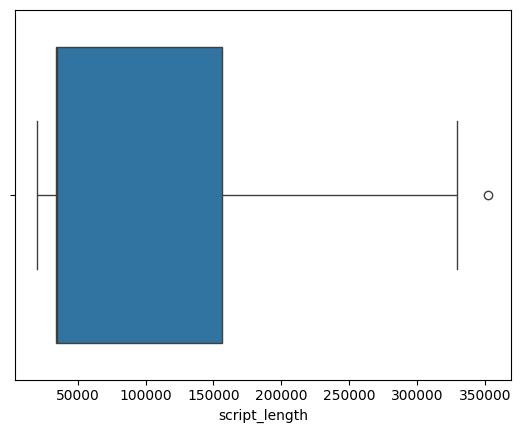

index,movie_title,date,script,genre,writers,movie_title_alphabetical,dataset,collapsed_movie_title,script_length
u32,str,date,str,str,str,str,str,str,u32
5,"""9""",2009-09-01,""" SEQ. 05 - PROLOGUE The F…","""Animation,Adventure,Drama,Fant…","""Pamela Pettler,Shane Acker""","""9""","""https://www.kaggle.com/dataset…","""9""",20240
107,"""Wall-E""",2008-06-01,"""EXT. SPACE FADE IN: …","""Animation,Adventure,Comedy,Dra…","""Andrew Stanton,Pete Docter""","""Wall-E""","""https://www.kaggle.com/dataset…","""walle""",21479
106,"""Up""",2009-05-01,""" 1. A 1930's NEWSREEL. …","""Animation,,Adventure,Comedy,Dr…","""Pete Docter,Bob Peterson,Thoma…","""Up""","""https://www.kaggle.com/dataset…","""up""",21500


...


index,movie_title,date,script,genre,writers,movie_title_alphabetical,dataset,collapsed_movie_title,script_length
u32,str,date,str,str,str,str,str,str,u32
47,"""Forrest Gump""",null,""" …",null,null,"""Forrest Gump""","""Google Search""","""forrestgump""",283204
92,"""Seven Samurai""",null,"""SEVEN SAMURAI Written by Akira…",null,null,"""Seven Samurai""","""Google Search""","""sevensamurai""",329726
96,"""The Silence of the Lambs""",null,"""THE SILENCE OF THE LAMBS by Te…",null,null,"""Silence of the Lambs The""","""Google Search""","""thesilenceofthelambs""",352653


In [31]:
# is the script a strange length?
dfout = dfout.with_columns(
    pl.col("script").str.len_chars().alias("script_length")
)
sns.boxplot(
    x = dfout["script_length"]
)
plt.show()

display(
    dfout.sort("script_length").head(3)
)
print("...")
display(
    dfout.sort("script_length").tail(3)
)

Let's check the shortest script in the dataset

Looks fine to me

In [32]:
shortest_script = dfout.filter(pl.col("script_length") == dfout["script_length"].min())[0, "script"]
print(shortest_script[:300])
print("...")
print(shortest_script[-300:])

 SEQ. 05 - PROLOGUE
 
 The Focus Features logo appears on screen and we slide INTO
 the "O" in Focus.
 
 Stock dissolves from 35mm to 16mm. BLACK & WHITE. GRAINY 
 like OLD DOCUMENTARY FOOTAGE.
 
 SCIENTIST'S VOICE
 Experiment 208 day 20...
 
 
 INT. SCIENTIST'S LAB - DAY

 We see an e
...
ther of pearl and wire hat bound together as an
 almost papal-like headpiece and carries a staff made from an
 old gear with a bell attached.
 
 pulls at 9 with his staff displaying the number on his
 back.
 
 1
 hat's this?
 
 turns and glares at 5 like a general glaring at a new
 privat


Now the longest

Looks normal

In [34]:
longest_script = dfout.filter(pl.col("script_length") == dfout["script_length"].max())[0, "script"]
print(longest_script[:300])
print("...")
print(longest_script[-300:])

THE SILENCE OF THE LAMBS
by
Ted Tally
Based on the novel by
Thomas Harris
This screenplay has been converted to a PDF file by ScreenTalk™
http://www.screentalk.org
FADE IN:FADE IN:
INT. GRUBBY HOTEL CORRIDOR - DAY (DIMLY LIT)INT. GRUBBY HOTEL CORRIDOR - DAY (DIMLY LIT)
A woman's face BACKS INTO SHOT
...
ders him for a genial moment, then raises the littleConsiders him for a genial moment, then raises the little
pen-knife. His eyes are twinkling.pen-knife. His eyes are twinkling.
DR. LECTERDR. LECTER
Well, Dr. Chilton. Shall we begin?Well, Dr. Chilton. Shall we begin?
FADE OUTFADE OUT
THE ENDTHE END


## 2. Non Alphanumeric Characters

Let's make sure none of the scripts are filled with pdf relics

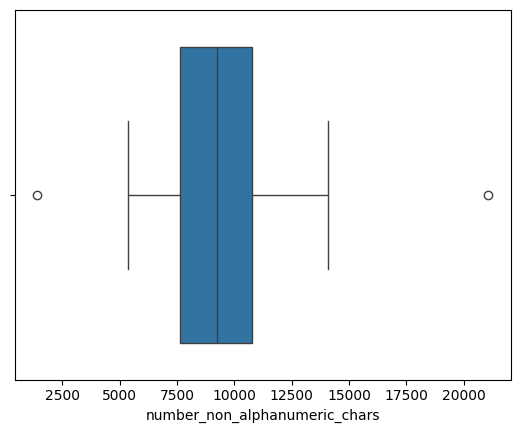

index,movie_title,date,script,genre,writers,movie_title_alphabetical,dataset,collapsed_movie_title,script_length,number_non_alphanumeric_chars
u32,str,date,str,str,str,str,str,str,u32,u32
96,"""The Silence of the Lambs""",null,"""THE SILENCE OF THE LAMBS by Te…",null,null,"""Silence of the Lambs The""","""Google Search""","""thesilenceofthelambs""",352653,21078
23,"""The Batman""",null,"""Rev. 12/17/20 (Blue) THE BATM…",null,null,"""Batman The""","""Google Search""","""thebatman""",195691,14096
98,"""Spider Man No Way Home""",null,"""Written as Written by Chris Mc…",null,null,"""Spider Man No Way Home""","""Google Search""","""spidermannowayhome""",205954,13349
25,"""Black Panther Wakanda Forever""",null,"""SUMMER BREAK Written by Ryan C…",null,null,"""Black Panther Wakanda Forever""","""Google Search""","""blackpantherwakandaforever""",236468,13250
42,"""Elvis""",null,"""ELVIS Screenplay by BAZ LUHRMA…",null,null,"""Elvis""","""Google Search""","""elvis""",218351,12944


In [ ]:
dfout = dfout.with_columns(
    pl.col("script").str.count_matches(r'[^A-z0-9\s]')
    .alias("number_non_alphanumeric_chars")
)

sns.boxplot(
    x = dfout["number_non_alphanumeric_chars"]
)
plt.show()

dfout.sort("number_non_alphanumeric_chars", descending=True)\
    .head()

The script doesn't look damaged to me

In [37]:
most_punctuation_chars = dfout.filter(pl.col("number_non_alphanumeric_chars") == dfout["number_non_alphanumeric_chars"].max())[0, "script"]
print(most_punctuation_chars[:300])
print("...")
print(most_punctuation_chars[-300:])

THE SILENCE OF THE LAMBS
by
Ted Tally
Based on the novel by
Thomas Harris
This screenplay has been converted to a PDF file by ScreenTalk™
http://www.screentalk.org
FADE IN:FADE IN:
INT. GRUBBY HOTEL CORRIDOR - DAY (DIMLY LIT)INT. GRUBBY HOTEL CORRIDOR - DAY (DIMLY LIT)
A woman's face BACKS INTO SHOT
...
ders him for a genial moment, then raises the littleConsiders him for a genial moment, then raises the little
pen-knife. His eyes are twinkling.pen-knife. His eyes are twinkling.
DR. LECTERDR. LECTER
Well, Dr. Chilton. Shall we begin?Well, Dr. Chilton. Shall we begin?
FADE OUTFADE OUT
THE ENDTHE END


Very reasonable punctuation characters

In [38]:
matches = re.findall(r'[^A-z0-9\s]', most_punctuation_chars)

non_alphanumeric_counts_sotl = Counter(matches)

non_alphanumeric_counts_sotl

Counter({'.': 9322,
         ',': 5326,
         "'": 1910,
         '-': 1514,
         '(': 730,
         ')': 730,
         '?': 662,
         ':': 309,
         '"': 224,
         '!': 206,
         ';': 128,
         '/': 8,
         '&': 6,
         '$': 2,
         '™': 1})

## 3. Diacritics

Let's make sure the only films including foreign languages have a large amount of diacritics

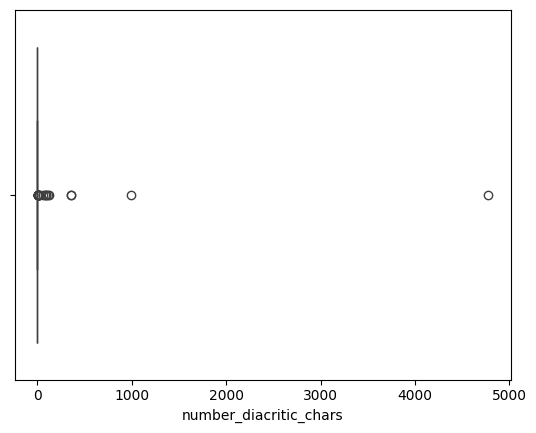

movie_title,number_diacritic_chars
str,u32
"""Cidade de Deus (City of God)""",4778
"""The Northman""",990
"""The Lord of the Rings The Retu…",357
"""Schindler's List""",357
"""Encanto""",128


In [46]:
diacritics_regex = r'[À-ž]'

dfout = dfout.with_columns(
    pl.col("script").str.count_matches(diacritics_regex)
    .alias("number_diacritic_chars")
)

sns.boxplot(
    x = dfout["number_diacritic_chars"]
)
plt.show()

dfout.sort("number_diacritic_chars", descending=True)\
    .select(pl.col("movie_title", "number_diacritic_chars")).head()

All of these make sense

## 4. Special Characters (Excluding Diacritics)

Let's make sure none of the scripts are filled with pdf relics

In [67]:
rare_chars_regex = r'[^A-Za-zÀ-ÖØ-öø-ÿ0-9\s\.\,\;\'\"\-\_\(\)\!\?’]'

test_regex = re.findall(rare_chars_regex, "don't match! døñ't ˆmå†ç˙  $@#yes^&match*")
[match for match in test_regex]

['ˆ', '†', '˙', '$', '@', '#', '^', '&', '*']

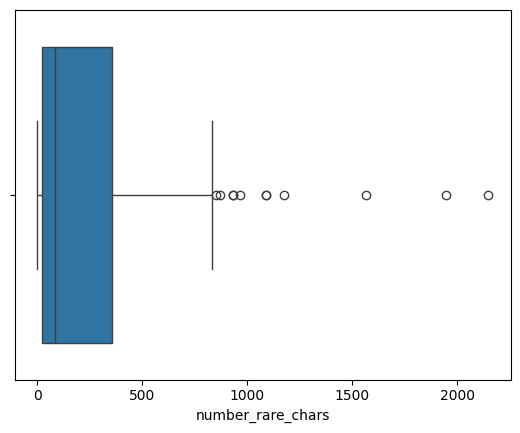

movie_title,number_rare_chars
str,u32
"""12 Angry Men""",2148
"""Black Panther Wakanda Forever""",1948
"""Deadpool & Wolverine""",1565
"""Goodfellas""",1177
"""Luca""",1088


In [68]:
dfout = dfout.with_columns(
    pl.col("script").str.count_matches(rare_chars_regex)
    .alias("number_rare_chars")
)

sns.boxplot(
    x = dfout["number_rare_chars"]
)
plt.show()

dfout.sort("number_rare_chars", descending=True)\
    .select(pl.col("movie_title", "number_rare_chars")).head()

No issues here, looks like 12 Angry Men just uses the # character

(The script was titled "Summer Break" by the author for secrecy)

In [73]:
most_rare_chars = dfout.filter(pl.col("number_rare_chars") == dfout["number_rare_chars"].max())[0, "script"]

matches = re.findall(rare_chars_regex, most_rare_chars)

rare_counts = Counter(matches)

display(rare_counts)

print(most_rare_chars[:300])
print("...")
print(most_rare_chars[3150:3300])
print("...")
print(most_rare_chars[-300:])

Counter({'#': 2109, ':': 36, '‘': 2, '”': 1})

1.
NOTE: The notes on characters are extremely brief, since it is felt that what they are and who they are will he revealed in their dialogue and actions during the course of the film.
FOREMAN: 35 years old. Assistant high school football coach.
A small, petty man who is at first vary of, and then i
...
round him, but a man who will honestly seek Justice because he has suffered through so much injustice.
Juror #12: 30 years old. Advertising man. A sli
...
ft, some right, same going straight ahead.
Camera moves back and up, ending with a long shot, through the pelting rain, of the steps and the jurors spreading out silently in all directions, never to see each other again.
And finally they are gone, and the rain beats down on the empty steps.
FADE OUT


In [76]:
for i in range(1, 5):
    check = dfout.sort(pl.col("number_rare_chars"), descending=True)[i]
    print(i)
    print(check[0, "movie_title"])

    matches = re.findall(rare_chars_regex, check[0, "script"])

    rare_counts = Counter(matches)

    display(rare_counts)
    print("-"*60)

1
Black Panther Wakanda Forever


Counter({'/': 1055,
         '*': 810,
         '“': 22,
         '”': 21,
         ':': 19,
         '#': 10,
         '%': 4,
         '$': 4,
         '–': 2,
         '…': 1})

------------------------------------------------------------
2
Deadpool & Wolverine


Counter({'*': 748,
         '/': 569,
         ':': 131,
         '”': 40,
         '“': 39,
         '‘': 35,
         '&': 2,
         '©': 1})

------------------------------------------------------------
3
Goodfellas


Counter({':': 392,
         '~': 241,
         '·': 208,
         '•': 89,
         '/': 37,
         '>': 32,
         '\xad': 25,
         '*': 22,
         '#': 19,
         '<': 18,
         '\\': 18,
         '$': 17,
         '{': 15,
         '}': 15,
         '£': 8,
         'µ': 6,
         '¥': 4,
         '»': 2,
         '§': 2,
         '©': 1,
         '[': 1,
         '¢': 1,
         '«': 1,
         '=': 1,
         '&': 1,
         '¼': 1})

------------------------------------------------------------
4
Luca


Counter({'/': 480,
         '©': 238,
         '•': 238,
         ':': 75,
         '“': 21,
         '”': 21,
         '%': 3,
         '[': 3,
         ']': 3,
         '#': 3,
         '&': 3})

------------------------------------------------------------


I ended up reading a good portion of the goodfellas script since I was worried about some of the characters from the printout above. It definitely has some parsing issues as indicated in the below printout, but it is overall in fine quality and does not need to be excluded or replaced.

In [79]:
goodfellas_script = dfout.filter(pl.col("movie_title") == pl.lit("Goodfellas"))[0, "script"]

print(goodfellas_script[:500])

GOOD FELLAS 
Written by 
Nicholas Pileggi 
and 
Martin Scorsese 
Rev. 06/28/89 (Blue) 
Rev. 09/08/89 (Pink) 
Based on the book by Nicholas Pileggi 
WA? .. HER BROS. INC. 
~000 ~arner Boulevard 
Berl:><J,,k, C11i£ornia 91522 
REVISED DRAFT 
January 12, 1989 
© 1989 
WARNER BROS. INC. 
All Rights Reserved 
1 
JUNE 11, 1970: QUEENS, NEW YORK. 
INT. SUITE - NIGHT 
A smoky, overdecorated cocktail lounge and nightclub on 
Queens Boulevard. Sergio Franchi is in full voice on the 
JUKEBOX. It is after m


In [80]:
dfout.head()

index,movie_title,date,script,genre,writers,movie_title_alphabetical,dataset,collapsed_movie_title,script_length,number_non_alphanumeric_chars,number_diacritic_chars,number_rare_chars
u32,str,date,str,str,str,str,str,str,u32,u32,u32,u32
0,"""12 Angry Men""",null,"""1. NOTE: The notes on characte…",null,null,"""12 Angry Men""","""Google Search""","""12angrymen""",157913,10495,0,2148
1,"""15 Minutes""",null,"""FADE IN on the words CZECH…","""Action,Crime,Thriller""","""John Hertzfield""","""15 Minutes""","""https://www.kaggle.com/dataset…","""15minutes""",34160,1503,0,5
2,"""2012""",2008-02-01,"""OVER BLACK …","""Action,Adventure,Drama,Sci-Fi,…","""Roland Emmerich,Harald Kloser""","""2012""","""https://www.kaggle.com/dataset…","""2012""",33612,856,0,48
3,"""30 Minutes or Less""",2009-12-01,"""The following is very loosely …","""Action,Adventure,Comedy""","""Michael Diliberti,Matthew Sull…","""30 Minutes or Less""","""https://www.kaggle.com/dataset…","""30minutesorless""",33603,917,0,7
4,"""48 Hrs""",null,"""FADE IN: OPEN…","""Action,Comedy,Thriller""","""Steven E. De Souza,Walter Hill…","""48 Hrs""","""https://www.kaggle.com/dataset…","""48hrs""",33794,965,0,1


In [81]:
dfout = dfout.drop(pl.col("collapsed_movie_title", "script_length", 
    "number_non_alphanumeric_chars", "number_diacritic_chars", "number_rare_chars"))

# Add Release Year

We bring in an alternate data source to add the release year and genres to the rows where we are missing those values.

In [93]:
# IMDB Movie Dataset (title-basics.tsv)
# https://www.kaggle.com/datasets/ashirwadsangwan/imdb-dataset?select=title.basics.tsv
imdb = pl.scan_csv("data/in/imdb-movie-dataset-title-basics.tsv", 
    separator='\t',
    null_values = {"startYear": '\\N', "endYear": '\\N'},
    quote_char=None,
    schema_overrides={
        "titleType": pl.String,
        "primaryTitle": pl.String,
        "originalTitle": pl.String,
        "startYear": pl.Int16,
        "endYear": pl.Int16,
        "genres": pl.String,
        "runtimeMinutes": pl.Int32
    },
    ignore_errors=True
)

imdb_filtered_joinable = imdb.filter(
    # include only movies
    (pl.col("titleType").str.to_lowercase() == pl.lit("movie")) & \
    # with a year
    (pl.col("startYear").is_not_null())
).with_columns(
    # create more joinable title
    # by sending to lowercase
    # removing punctuation and excess whitespace
    pl.col("primaryTitle").cast(pl.String, strict=False).str.to_lowercase()
    .str.replace_all(r'[\.\:\-\_\(\)]', ' ').str.replace_all(r'\s+', ' ')
    .alias("join_movie_title")
).collect()

dfx = dfout.filter(pl.col("date").is_null() | pl.col("genre").is_null())\
    .with_columns(
        # create more joinable title
        # by sending to lowercase
        # removing punctuation and excess whitespace
        pl.col("movie_title").str.to_lowercase()
        .str.replace_all(r'[\.\:\-\_\(\)]', ' ').str.replace_all(r'\s+', ' ')
        .alias("join_movie_title")
    ).join(
        imdb_filtered_joinable,
        on = "join_movie_title",
        how="left"
    )

print(
    dfx["startYear"].is_null().sum(),
    "movies still missing release year"
)

4 movies still missing release year


We have a one-to-many join, but we need to filter down to the correct match between the movie titles.

In [83]:
dupd = dfx.filter(pl.col("index").is_duplicated()).sort(pl.col("index", "startYear"))

print(len(set(dupd["index"])), " individual movies with duplicate joins")

print(dupd.shape[0], " total duplicates")

display(
    dupd.select(pl.col("movie_title", "primaryTitle", "startYear", "date", "titleType", "genres", "dataset")).head()
)

18  individual movies with duplicate joins
67  total duplicates


movie_title,primaryTitle,startYear,date,titleType,genres,dataset
str,str,i16,date,str,str,str
"""15 Minutes""","""15 Minutes""",1997,null,"""movie""","""\N""","""https://www.kaggle.com/dataset…"
"""15 Minutes""","""15 Minutes""",2001,null,"""movie""","""Action,Crime,Drama""","""https://www.kaggle.com/dataset…"
"""All Quiet On The Western Front""","""All Quiet on the Western Front""",1930,null,"""movie""","""Drama,War""","""Google Search"""
"""All Quiet On The Western Front""","""All Quiet on the Western Front""",2022,null,"""movie""","""Drama,History,War""","""Google Search"""
"""Amsterdam""","""Amsterdam""",2013,null,"""movie""","""Thriller""","""Google Search"""


So we map the title to the correct release year, then filter to rows that match that condition

In [84]:
correct = {
    "All Quiet On The Western Front": 2022,
    "Amsterdam": 2022,
    "15 Minutes": 2001,
    "Avatar": 2009,
    "Barbie": 2023,
    "Elemental": 2023,
    "Elvis": 2022,
    "Fight Club": 1999,
    "Harry Potter and the Half Blood Prince": 2009,
    "Inception": 2010,
    "Inside Out": 2015,
    "It's a Wonderful Life": 1946,
    "The Lord of the Rings The Fellowship of the Ring": 2001,
    "Luca": 2021,
    "Pinocchio": 2022,
    "Star Wars Episode V The Empire Strikes Back": 1980,
    "Top Gun": 1986
}

dfxc = dfx.with_columns(
    # map movie title to release year,
    # then select rows where startYear is equivalent
    correct = pl.col("movie_title").replace_strict(correct, default=-1) \
        == pl.col("startYear")
).filter(
    # keep rows that are non duplicated
    # or have the correct release year
    ~pl.col("index").is_duplicated() | pl.col("correct")
)
dfxc.shape

(57, 19)

Now we join this back to the original data

In [ ]:
dfout = dfout.join(
    # only need the new columns
    dfxc.select("index", "startYear", "genres"),
    how="left",
    on="index"
).with_columns(
    # consolidate the two different date columns
    # into one year column
    year_from_date = pl.col("date").dt.year()
).with_columns(
    year = pl.coalesce(["year_from_date", "startYear"])
).drop(pl.col("year_from_date", "startYear"))

In [87]:
display(
    dfout.filter(pl.col("year").is_null()).select(pl.col("index", "movie_title"))
)
# manually add the year for movies where it is missing
manual_additions = [
    (4, 1982),
    (32, 2002),
    (49, 2024),
    (70, 2003),
    (104, 1986),
]

for idx, year in manual_additions:
    dfout[idx, "year"] = year

index,movie_title
u32,str
4,"""48 Hrs"""
32,"""Cidade de Deus (City of God)"""
49,"""Gladiator 2"""
70,"""The Lord of the Rings The Retu…"
104,"""Transformers: The Movie"""


**Now we consolidate the two genre columns**

To do so, we concatenate the two string columns together, repair any damage to the string, then split the elements into a set, then rejoin them to string in alphabetical order

In [88]:
dfout = dfout.with_columns(
    # concat the two genre columns with a , separator
    pl.concat_str([pl.col("genre"), pl.lit(","), pl.col("genres")], ignore_nulls=True)
    # replace any characters that are not
    # letters or a comma
    .str.replace_all(r'[^A-z\,]', "")
    # remove trailing and leading commas
    .str.replace_all(r'^,|,$', "")
    # split the concatenated string into elements
    .str.split(",").map_elements(lambda x: list(set(x)))
    # sort those elements
    .list.sort()
    # then join back together as a string
    .list.join(",")
    # Null values
    .replace("", None)
    .alias("genre")
)\
    .drop("genres")

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


Done!

In [89]:
dfout.write_parquet("data/out/movie-script-dataset.parquet")